# Script for preprocessing of Tina's Calcium imaging data

### Dependencies: matplotlib, scikit image, h5py, numpy, pyqtgraph (interactive plots of 3D stacks), roi (custom python class for drawing rois)

### Overview of steps
1. Import tiff stack
2. Open using pyqtgraph (interactive browsing of data)
3. Simple movement correction
4. Extraction of time series from ROIs
5. Some visualizations of ROI time series

In [1]:
from skimage.io import imread, imshow
import h5py
from matplotlib import pyplot as plt
import numpy as np
from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

In [2]:
# import custom roi module
path.insert(1, getcwd() + sep + 'utils')

#from roiDrawing import roi

from roiVisualization import illustrateRois
from analogTMprocessing import processTMSignals, myInterpol, mysmooth

### 0. Choose files to analyse

In [3]:
parentDir = sep.join(getcwd().split(sep)[:-1])

rawtiff = 'JF549-BAPTA_MPM/170920/170920_549_whitenoise3cw_00001.tif'

rawh5 = 'JF549-BAPTA_MPM/170920/170920_whitenoise3ccw_0001.h5'

[dye, date, expt] = rawtiff.split(sep)
plotDir = parentDir + sep + 'Plots'

In [4]:
# Generate directory where to save plots
saveDir = sep.join([plotDir,dye,date,expt[:-4]])
if not exists(saveDir):
    makedirs(saveDir)

### 1. Import previously extracted ROIs

#### Import ROIs

In [5]:
roiData = np.load(saveDir + sep + 'roiData_'+expt[:-4]+'.npy').item()

In [6]:
roiData.keys()

dict_keys(['imgData', 'img', 'numframes', 'slctframes', 'fpv', 'numRoi', 'roiTS', 'roiShapes'])

#### TODO: Set up color scheme and visualisze ROIs on reference image

#### Visualize ROIs

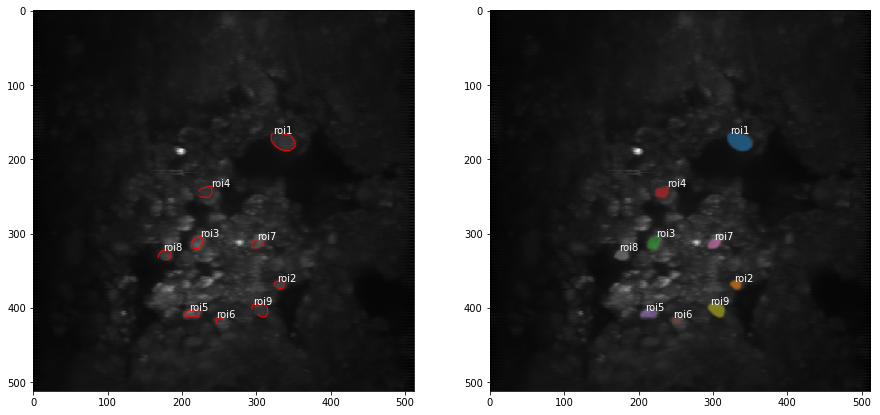

In [7]:
roifig = illustrateRois(roiData)

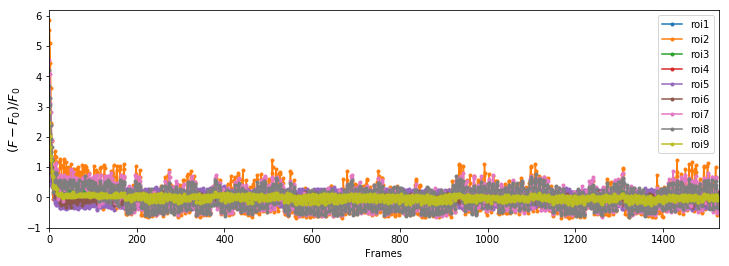

In [8]:
tracefig, ax = plt.subplots(1, 1, figsize=(12,4))

ts = 0
te = roiData['numframes']

frameSlc = np.linspace(ts, te, te-ts)
for r in np.arange(roiData['numRoi']):
    
    bl = roiData['roiTS'][ts:te,r].mean(0)
    ax.plot((roiData['roiTS'][ts:te,r]-bl)/bl, '.-')
        
    ax.set_xlabel('Frames')
    ax.set_xlim(ts, te)
    
    ax.set_ylabel('$(F - F_0) / F_0$', fontsize=13)
    
ax.legend(['roi'+str(r+1) for r in np.arange(roiData['numRoi'])],loc=1);

## Process h5 file (behavior, trigger pulses)
### Set experimental parameter

In [9]:
tmParams = {
    'px2mm': 0.03,
    'calibParam':(1.5, 1.5),
    'rBall':48, #cm
    'tickLength': 0.002, #s
    'tickAmp':0.2 #V
}
arenaSize = 270 # degrees

trialS = 120

wsParams = {
    'fps': 20000,
    'channelNames': ['x1','x2','y1','y2','arena','unknown','RearCamFramClock','TwoPFrameClock'],
    'Offsets': [2.05, 2.04, 2.05, 2.05], #Offsets of X0,X1,Y0,Y1 tick channels
    'triggerTH': 2
}

# You can check chanel names using list(myh5['header']['AIChannelNames'])

### Load file

In [10]:
myh5 = h5py.File(parentDir + sep + rawh5, 'r')
h5keys = [name for name in myh5]

print(h5keys)

['header', 'sweep_0001']


In [11]:
# Select sweep
sweepInd = 1

#for name in myh5[h5keys[sweepInd]]:
#    print(name)
    
sweepkey = h5keys[sweepInd]
sweepdat = list(myh5[h5keys[sweepInd]]['analogScans'])

In [12]:
scalingCoeffs = list(myh5['header']['Acquisition']['AnalogScalingCoefficients'][6])

### Quick visual check of the recording

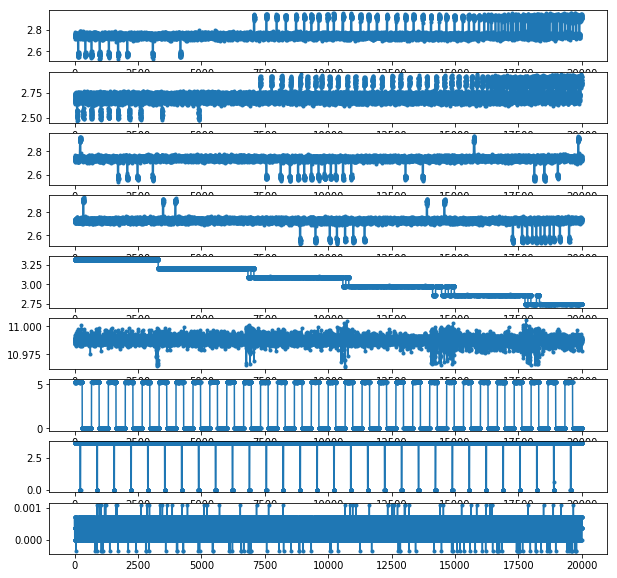

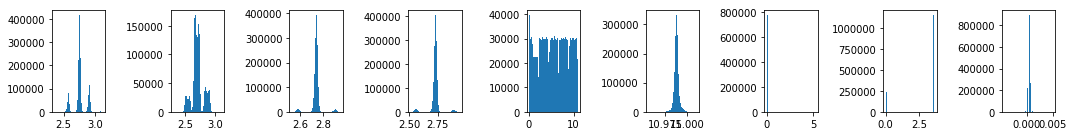

In [13]:
channelFig = plt.figure(figsize=(10,10))

tS = int(14*wsParams['fps'])
tE = int(15*wsParams['fps'])


for t in range(len(sweepdat)):
    ax = channelFig.add_subplot(len(sweepdat),1,t+1)
    ax.plot(sweepdat[t][tS:tE]*scalingCoeffs[0],'.-')
plt.show()

channelHistFig = plt.figure(figsize=(15,2))

tS = 0
tE = -1

for t in range(len(sweepdat)):
    ax = channelHistFig.add_subplot(1,len(sweepdat),t+1)
    ax.hist(sweepdat[t][tS:tE]*scalingCoeffs[0], bins=50)

channelHistFig.tight_layout()
plt.show()

### Extract and process treadmill measurements

In [14]:
# Store treadmill values in dict
tm_raw = {}
for ch in range(4):
    tm_raw[wsParams['channelNames'][ch]] = sweepdat[ch]*scalingCoeffs[0]

# extract arena position
arena_raw = sweepdat[4]

# rescale arena signal
arena = arenaSize*(arena_raw - 0.5*np.max(arena_raw))/np.max(arena_raw)

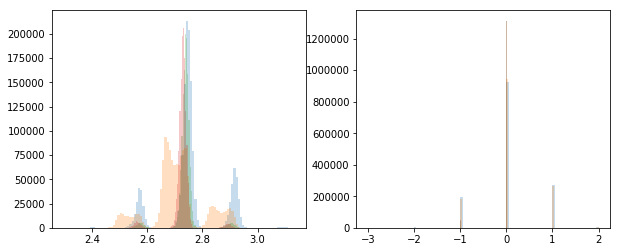

In [15]:
tm_ticks = processTMSignals(tm_raw, tmParams, wsParams)

sweepFig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
for i, k in enumerate(tm_raw.keys()):
    ax1.hist(tm_raw[k], 100, alpha=0.25); 
for i, k in enumerate(tm_ticks.keys()):
    ax2.hist(tm_ticks[k], 100, alpha=0.25); 

In [16]:
conversionFactor_pitch = tmParams['px2mm']*float(tmParams['calibParam'][0])
conversionFactor_yaw = tmParams['px2mm']*float(tmParams['calibParam'][1])

gammaRad = 45*np.pi/180.0

time = np.linspace(0, trialS, len(tm_ticks['x1']))

# compute virtual rotation of fly
vFwd = - (tm_ticks['y1'] + tm_ticks['y2']) * np.cos(gammaRad); #add components along longitudinal axis
vSide = - (tm_ticks['y1'] - tm_ticks['y2']) * np.sin(gammaRad); #add components along transversal axis
vRot = - (tm_ticks['x1'] + tm_ticks['x2'])/2 #average measured displacement along aximuth

# convert A.U. --> pixel --> mm
vFwd = vFwd * conversionFactor_pitch # use scaling factor for pitch
vSide = vSide * 0.5*(conversionFactor_yaw + conversionFactor_pitch) #use mean
vRot = vRot * conversionFactor_yaw # use scaling factor for yaw

In [17]:
# Compute path
# Assume initial position (0 0 0) = (x-coord, y-coord, theta): 
# --> fly in origin, aligned with x axis (head forward)
# During measurement coordinate system is fly-centered, moves with fly.
# Compute all changes along those axes by updating theta and
# projecting the position changes onto the fixed coordinate system

dt = np.hstack((np.diff(time),np.mean(np.diff(time)) ))

theta = np.cumsum(vRot * dt)
theta = np.mod((theta + np.pi),2*np.pi) - np.pi

# movement in x and y direction
yTM_i = vSide * np.cos(-theta) - vFwd * np.sin(-theta) #compute increments x_i
yTM = np.cumsum(yTM_i* dt) # integrate x_i to get path

xTM_i = vSide * np.sin(-theta) + vFwd * np.cos(-theta)
xTM = np.cumsum(xTM_i * dt)

transV = np.hypot(xTM_i, yTM_i)

In [18]:
# downsample through linear interpolation

fps_ds = 500

time_ds = np.linspace(time[0], time[-1], int(fps_ds*time[-1]))

vFwd_ds = myInterpol(time_ds, time[:], vFwd)
vSide_ds = myInterpol(time_ds, time[:], vSide)
vRot_ds = myInterpol(time_ds, time[:], vRot)
arena_ds = myInterpol(time_ds, time[:], arena)

In [19]:
# convert to cm/s
dt = np.hstack((np.diff(time_ds),np.mean(np.diff(time_ds)) ))
vFwd_ds = vFwd_ds / dt
vSide_ds = vSide_ds / dt
vRot_ds =  vRot_ds / dt

rotV_ds = vRot_ds / tmParams['rBall'] #cm/s to deg/s

theta_ds = np.cumsum(rotV_ds * dt)
theta_ds = np.mod((theta_ds + np.pi),2*np.pi) - np.pi

# movement in x and y direction
yTM_i = vSide_ds * np.cos(-theta_ds) - vFwd_ds * np.sin(-theta_ds) #compute increments x_i
yTM_ds = np.cumsum(yTM_i* dt) # integrate x_i to get path

xTM_i = vSide_ds * np.sin(-theta_ds) + vFwd_ds * np.cos(-theta_ds)
xTM_ds = np.cumsum(xTM_i * dt)

transV_ds = np.hypot(xTM_i, yTM_i)

#### Visualize behavior traces

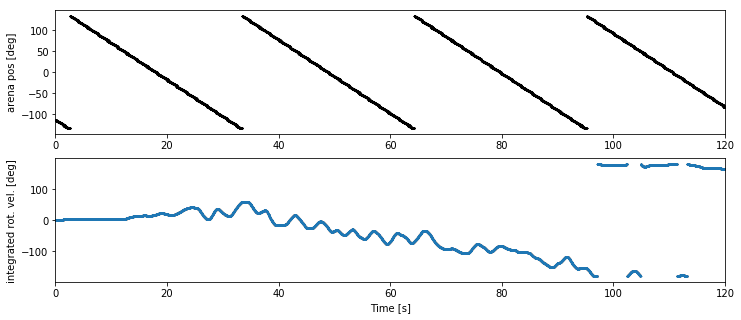

In [20]:
yawFig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,5))

ax1.plot(time_ds, arena_ds, 'k.', markersize=1)
ax1.set_ylabel('arena pos [deg]')
ax1.set_xlim(0,trialS)
ax2.plot(time_ds, np.mod(np.cumsum(rotV_ds*dt*180/np.pi)+180,360)-180,'.', markersize=1)
ax2.set_ylabel('integrated rot. vel. [deg]')
ax2.set_xlabel('Time [s]')
ax2.set_xlim(0,trialS);

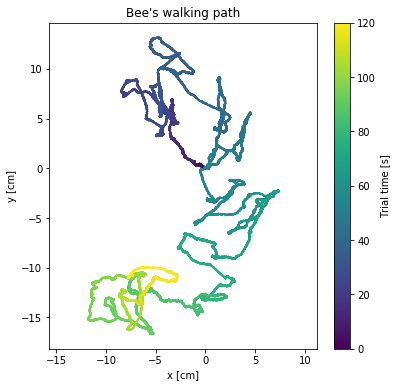

In [25]:
pathFig, axs = plt.subplots(1,1,figsize=(6,6))

cb = axs.scatter(xTM_ds, yTM_ds, s=1,c=time_ds)
axs.set_xlabel('x [cm]')
axs.set_ylabel('y [cm]')
axs.set_title("Bee's walking path")
axs.axis('equal')
plt.colorbar(cb, ax=axs, label='Trial time [s]')

pathFig.savefig(saveDir+sep+'path_'+expt[:-4]+'.pdf', format = 'pdf')

### Extract imaging and behavior video frame triggers

In [26]:
# Extract raw trigger traces
trig_raw = {}
for ch in np.arange(6,8):
    trig_raw[wsParams['channelNames'][ch]] = sweepdat[ch]*scalingCoeffs[0]
    
# Binarize trigger traces
trig_bin = {}
for ch in np.arange(6,8):
    trig_bin[wsParams['channelNames'][ch]] = \
    np.squeeze((trig_raw[wsParams['channelNames'][ch]] >= wsParams['triggerTH']).astype('int'))

In [27]:
# Find time points of rising edge
baslerRE = np.hstack((0,np.diff(trig_bin['RearCamFramClock'])))
baslerInds = np.where(baslerRE>0)[0]
baslerFrame = time[baslerInds]

tpRE = np.hstack((0,np.diff(trig_bin['TwoPFrameClock'])))
twoPInds = np.where(tpRE>0.5)[0]
twoPFrame = time[twoPInds]

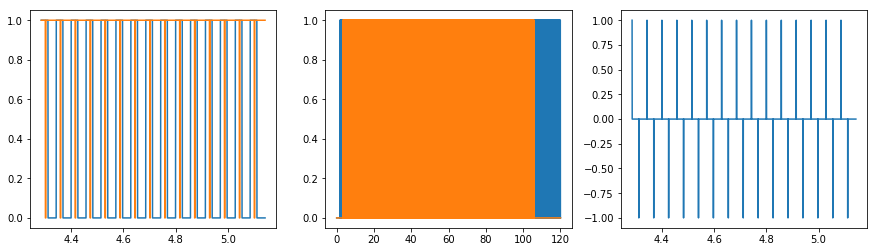

In [28]:
trigFig, axs = plt.subplots(1,3,figsize=(15,4))
ts = 50000
te = 60000

axs[0].plot(time[ts:te], trig_bin['RearCamFramClock'][ts:te])
axs[0].plot(time[ts:te], trig_bin['TwoPFrameClock'][ts:te])

axs[1].plot(time, trig_bin['RearCamFramClock'])
axs[1].plot(time, trig_bin['TwoPFrameClock'])

axs[2].plot(time[ts:te], baslerRE[ts:te])

### Resample treadmill measurements and ROI traces at frame trigger times
#### Potentially skip frames, if volume was collapsed:

In [45]:
twoPInds = twoPInds[::roiData['fpv']]
twoPFrame = twoPFrame[::roiData['fpv']]

#### Deal with missing frames due to movement correction

In [52]:
twoPInds = twoPInds[np.where(roiData['slctframes'])[0]]
twoPFrame = twoPFrame[np.where(roiData['slctframes'])[0]]

#### Check if frames in the two recordings match

In [53]:
if roiData['numframes'] == len(twoPInds):
    print('Detected # of 2P frames in ws file ('+str(len(twoPInds))+') and tiff file ('+str(roiData['numframes'])+') match!')
    print('Now aligning data from the following files:')
    print('\t- ' + rawtiff)
    print('\t- ' + rawh5)
else:
    print('There is some problem withe the frame counts. Tiff and treamill recording disagree.')
    print('\t 2P: '+str(len(twoPInds)))
    print('\t ROIs: '+str(roiData['numframes']))

Detected # of 2P frames in ws file (1527) and tiff file (1527) match!
Now aligning data from the following files:
	- JF549-BAPTA_MPM/170920/170920_549_whitenoise3cw_00001.tif
	- JF549-BAPTA_MPM/170920/170920_whitenoise3ccw_0001.h5


In [54]:
# Generate new time vector that starts counting at first 2P frame
time_2p = twoPFrame-twoPFrame[0]
fps_2p = len(time_2p)/time_2p[-1]

print('Trial length according to 2p frame counter: '+str(time_2p[-1])+' s (frame rate = '+str(fps_2p)+')')

# Resample treadmill measurements at 2P frame counts
xTM_2p = myInterpol(twoPFrame, time, xTM)
yTM_2p = myInterpol(twoPFrame, time, yTM)
theta_2p = myInterpol(twoPFrame, time, theta)
arena_2p = myInterpol(twoPFrame, time, arena)

Trial length according to 2p frame counter: 102.472701766 s (frame rate = 14.901529614)


In [55]:
# Recompute velocities from these counts
rotV_2p = np.hstack( (0, np.diff(theta_2p)) ) #tmParams['rBall'] 

# movement in x and y direction
transV_2p = np.hypot(np.hstack( (0, np.diff(xTM_2p)) ), np.hstack( (0, np.diff(yTM_2p)) ))

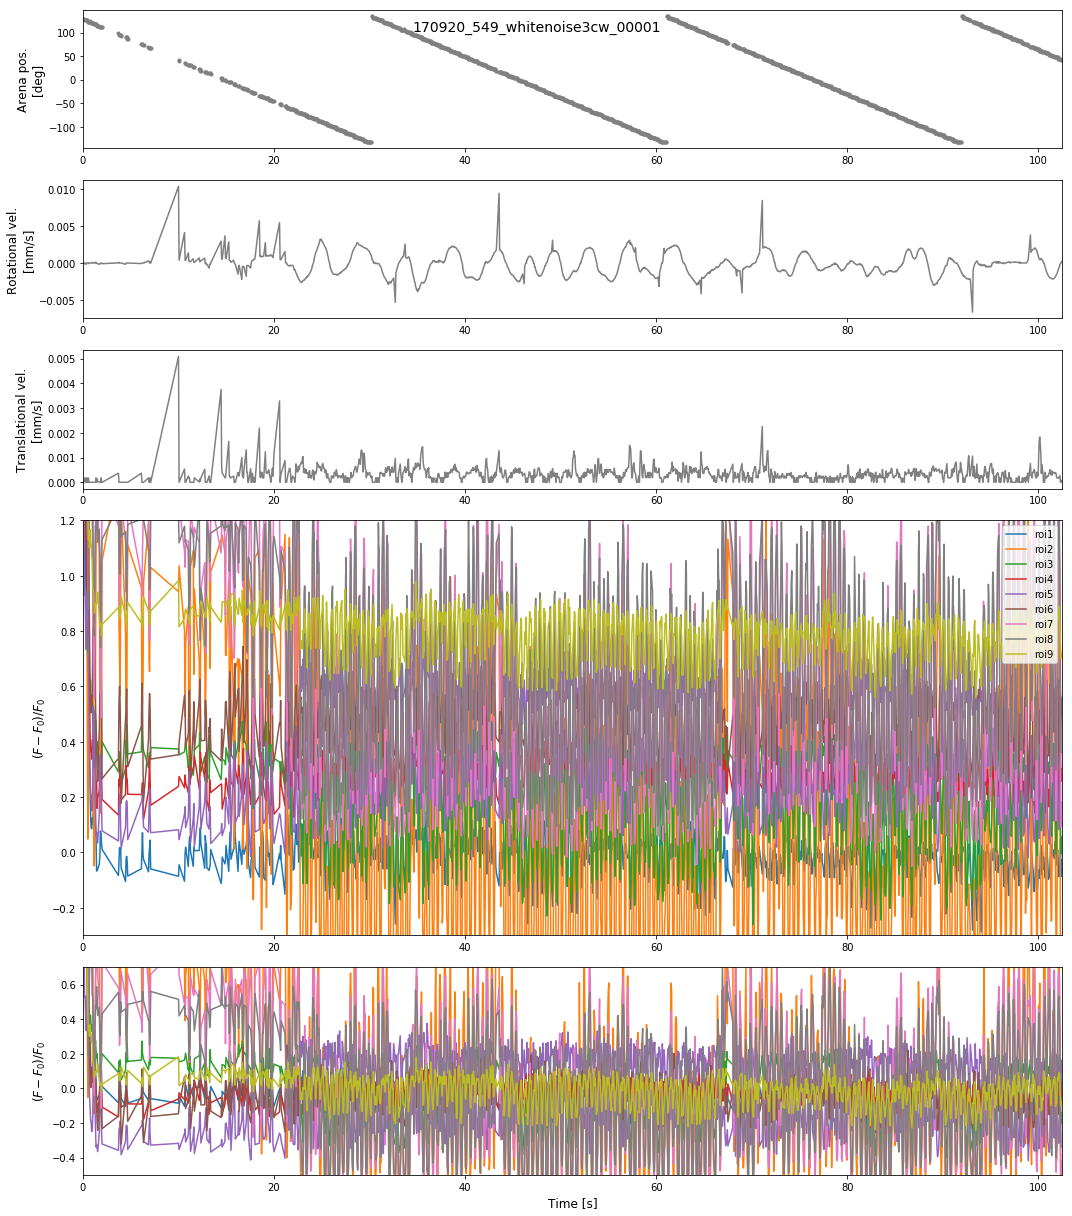

In [61]:
velROIFig, axs = plt.subplots(5,1,figsize=(15,17), gridspec_kw={'height_ratios':[1,1,1,3,1.5]})

roiOffset = 0.1

ts = 0
te = len(twoPInds)-1

axs[0].plot(time_2p[ts:te],arena_2p[ts:te],'.',color='grey')
axs[0].set_ylabel('Arena pos.\n[deg]', fontsize=12)

axs[1].plot(time_2p[ts:te],rotV_2p[ts:te],color='grey')
axs[1].set_ylabel('Rotational vel.\n[mm/s]', fontsize=12)

axs[2].plot(time_2p[ts:te], transV_2p[ts:te],color='grey')
axs[2].set_ylabel('Translational vel.\n[mm/s]', fontsize=12)


for r in np.arange(roiData['numRoi']):
    
    bl = roiData['roiTS'][ts:te,r].mean(0)
    axs[3].plot(time_2p[ts:te], (roiData['roiTS'][ts:te,r]-bl)/bl + roiOffset*r)
    axs[3].set_ylabel('$(F - F_0) / F_0$', fontsize=12)
    
    axs[4].plot(time_2p[ts:te], (roiData['roiTS'][ts:te,r]-bl)/bl)
    axs[4].set_ylabel('$(F - F_0) / F_0$', fontsize=12)
    
axs[3].set_ylim(-0.3,0.4+r*roiOffset)
axs[3].legend(['roi'+str(r+1) for r in range(roiData['numRoi'])],loc=1)

axs[4].set_ylim(-0.5,0.7)
axs[4].set_xlabel('Time [s]', fontsize=12)

for i in range(len(axs)):
    axs[i].set_xlim(time_2p[ts],time_2p[te])

velROIFig.suptitle(expt[:-4], fontsize=14)
velROIFig.tight_layout()

velROIFig.savefig(saveDir+sep+'walkingVel-ROIs_'+expt[:-4]+'.pdf', format = 'pdf')

### Plot ROI against bar position

### Plot ROI against walking velocities